In [97]:
import math

def is_odd(num: int):
    return num % 2 != 0

def get_kernel(elements: int):
    kernel = []
    for k in range(elements):
        i = k - math.floor(elements / 2)
        if is_odd(k):
            x = (-4 / (math.pi ** 2)) / (i ** 2)
            kernel.append(x)
        else:
            kernel.append(0)
    kernel[math.floor(elements / 2)] = 1
    return kernel

kernel = get_kernel(21)

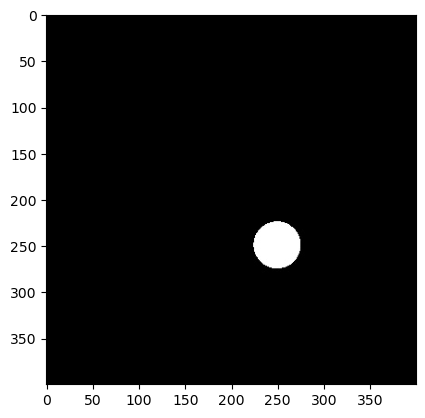

In [98]:
from matplotlib import image
from matplotlib import pyplot as plt
from skimage.draw import line_nd
import numpy as np

raw = np.average(np.array(image.imread('images/Kropka.jpg')), axis=2)
size = np.max(raw.shape) * 2
data = np.zeros([size, size])

center_x, center_y = np.array(data.shape) // 2

top_left_x = center_x - raw.shape[0] // 2
top_left_y = center_y - raw.shape[1] // 2

data[top_left_x:top_left_x + raw.shape[0], top_left_y:top_left_y + raw.shape[1]] = raw

plt.imshow(raw, cmap="gray")

In [103]:
import ipywidgets as widgets

# create widgets for three numbers and a checkbox
input_scans = widgets.FloatSlider(value=180, min=90, max=720, step=90, description='Step')
input_detectors = widgets.FloatSlider(value=180, min=90, max=720, step=90, description='Detectors')
input_fi = widgets.FloatSlider(value=180, min=45, max=270, step=45, description='Range')
use_filtering = widgets.Checkbox(value=False, description='Use filtering')

# display the widgets using a VBox layout
widgets.VBox([input_scans, input_detectors, input_fi, use_filtering])

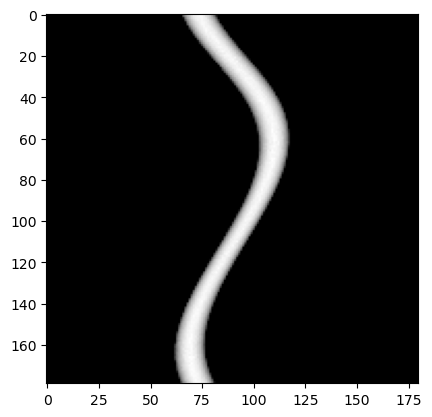

In [104]:
def circle_point(radians: float):
    x = math.sin(radians)
    y = math.cos(radians)
    return np.array([x, y])

def end_points(alpha: float, detectors, fi):
    points = np.array([])
    for i in range(detectors):
        x = math.sin(alpha + math.pi - (fi/2) + (i * (fi/(detectors-1))))
        y = math.cos(alpha + math.pi - (fi/2) + (i * (fi/(detectors-1))))
        points = np.array([*points, np.array([x, y])])
    return points


def generate_sinogram(step_angle, detectors, fi, filtering):
    def ray(data, start, stop):
        line = line_nd(start, stop)
        ray = data[line]
        return np.average(ray)

    angles = np.linspace(0, np.radians(360), num=math.floor(np.radians(360) // step_angle), endpoint=False)

    sinogram = []
    for angle in angles:
        slice = np.array([])
        start = circle_point(angle) * (size/2) + (size/2 - 1)
        for end_point in end_points(angle, detectors, fi):
            stop = end_point * (size/2) + (size/2 - 1)
            z = ray(data, start, stop)
            slice = np.append(slice, z)
        if filtering:
            slice = np.convolve(slice, kernel, mode='same')
        sinogram.append(slice)
    return sinogram

In [ ]:
sinogram = generate_sinogram(np.radians(360) / input_scans.value, int(input_detectors.value), np.radians(input_fi.value), use_filtering.value)
plt.imshow(sinogram, cmap="gray")

In [111]:
from ipywidgets import interact, widgets

step_angle = np.radians(360) / input_scans.value
detectors = int(input_detectors.value)
fi = np.radians(input_fi.value)

def reverse(sinogram, step_angle, detectors, fi):
    angles = np.linspace(0, np.radians(360), num=math.floor(np.radians(360) // step_angle), endpoint=False)

    inverse = [np.zeros(data.shape)]

    for (j, angle) in enumerate(angles):
        current = np.copy(inverse[-1])
        start = circle_point(angle) * (size/2) + (size/2 - 1)
        for (i, end_point) in enumerate(end_points(angle, detectors, fi)):
            stop = end_point * (size/2) + (size/2 - 1)
            out = line_nd(start, stop)
            current[out] += sinogram[j][i]
        inverse = [*inverse, current]


    final = []
    for i in inverse:
        center_x, center_y = np.array(data.shape) // 2
        original_size = size // 2
        center = i[center_x - original_size//2:center_x + original_size//2, center_y - original_size//2:center_y + original_size//2]
        final.append(center)

    normalized = (final - np.min(final)) * (255 / (np.max(final) - np.min(final)))

    return normalized

In [ ]:
output = reverse(sinogram, np.radians(360) / input_scans.value, int(input_detectors.value), np.radians(input_fi.value))

In [112]:
def show(iteration: int):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    mse = np.mean((raw - output[iteration]) ** 2) / 255

    axs[0].imshow(raw, cmap='gray')
    axs[1].imshow(sinogram, cmap='gray')
    axs[2].imshow(output[iteration], cmap='gray')

    axs[0].set_title('Original image')
    axs[1].set_title('Sinogram')
    axs[2].set_title('Reconstructed image' + str(mse))

interact(show, iteration=widgets.IntSlider(min=0, max=len(angles), step=1, value=len(angles)))

interactive(children=(IntSlider(value=179, description='iteration', max=179), Output()), _dom_classes=('widget…

<function __main__.show(iteration: int)>

In [117]:
def radon(scans, detectors, fi, filtering):
    sinogram = generate_sinogram(np.radians(360) / scans, int(detectors), np.radians(fi), filtering)
    output = reverse(sinogram, np.radians(360) / scans, int(detectors), np.radians(fi))
    return output

# Benchmark

Liczba detektorów zmienia się od 90 do 720 z krokiem 90,


In [118]:
tests = []

for d in range(90, 720, 90):
    test = radon(180, d, 180, False)
    tests.append(test)

[array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00,

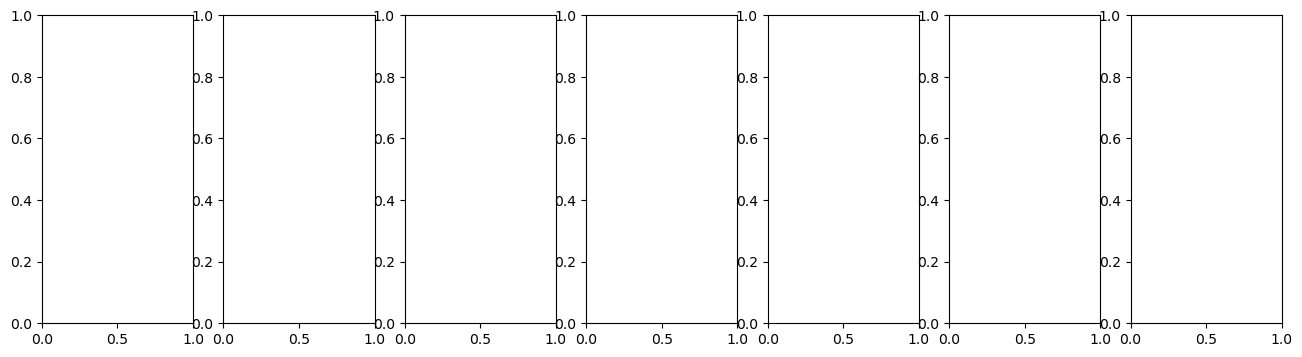

In [123]:
fig, axs = plt.subplots(1, len(tests), figsize=(16, 4))

print(tests)